In [1]:
import os
import sys
import glob
import matplotlib
import numpy as np
matplotlib.use('agg')
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from keras import backend as K
from keras import __version__
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Model
from keras.layers import Dense, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
from keras.preprocessing import image
from keras.models import load_model

Using TensorFlow backend.


In [2]:
IM_WIDTH, IM_HEIGHT = 299, 299 
NB_EPOCHS = 3
BAT_SIZE = 32
FC_SIZE = 1024
filepath="weights_3.h5"

%matplotlib inline

In [8]:
def get_nb_files(directory):
    """Get number of files by searching directory recursively"""
    if not os.path.exists(directory):
        return 0
    cnt = 0
    for r, dirs, files in os.walk(directory):
        for dr in dirs:
            cnt += len(glob.glob(os.path.join(r, dr + "/*")))
    return cnt

In [9]:
def setup_to_transfer_learn(model, base_model):
    """Freeze all layers and compile the model"""
    for layer in base_model.layers:
        layer.trainable = False
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [10]:
def add_new_last_layer(base_model, nb_classes):
    x = base_model.output
    x = Dropout(0.5)(x)
    x = AveragePooling2D((8, 8), border_mode='valid', name='avg_pool')(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)
    predictions = Dense(2, activation='sigmoid')(x)
    model = Model(input=base_model.input, output=predictions)
    return model

In [11]:
## For best Val ACC found, save the model at that epoch
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

/home/costa/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [12]:
def train(epochs, output_model_file, plot = True ):
    """Using transfer learning """
    train_img = 'train/' 
    validation_img = 'val/'
    nb_epoch = int(epochs)
    nb_train_samples = get_nb_files(train_img)
    nb_classes = len(glob.glob(train_img + "/*"))
    # data prep
    train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    validation_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

    
    train_generator = train_datagen.flow_from_directory(
			train_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    validation_generator = validation_datagen.flow_from_directory(
			validation_img,
			target_size=(299, 299),
			batch_size=32,
			class_mode='categorical'
			)
    if(K.image_dim_ordering() == 'th'):
        input_tensor = Input(shape=(3, 299, 299))
    else:
        input_tensor = Input(shape=(299, 299, 3))
    
    # setup model
    base_model = InceptionV3(input_tensor = input_tensor,weights='imagenet', include_top=False) #include_top=False excludes final FC layer
    model = add_new_last_layer(base_model, nb_classes)
    
    # transfer learning
    setup_to_transfer_learn(model, base_model)
    
    
    
    history_tl = model.fit_generator(train_generator,
                                   samples_per_epoch=320,
                                   nb_epoch=nb_epoch,
                                   validation_data=validation_generator,
                                   nb_val_samples=64,
                                   callbacks=[lr_reduce,checkpoint]) 
    model.save(output_model_file)
    if plot:
        plot_training(history_tl)

In [13]:
def plot_training(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    
    plt.plot(epochs, acc, 'r.')
    plt.plot(epochs, val_acc, 'r')
    plt.title('Training and validation accuracy')
    plt.savefig('accuracy.png')
    
    plt.figure()
    plt.plot(epochs, loss, 'r.')
    plt.plot(epochs, val_loss, 'r-')
    plt.title('Training and validation loss')
    plt.savefig('loss.png')

Found 7705 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


/home/costa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Update your `AveragePooling2D` call to the Keras 2 API: `AveragePooling2D((8, 8), name="avg_pool", padding="valid")`
  after removing the cwd from sys.path.
/home/costa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  # Remove the CWD from sys.path while we load stuff.
/home/costa/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:61: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/home/costa/anaconda3/lib/pyt

Epoch 1/10
10/10 [==============================] - 31s 3s/step - loss: 0.5372 - acc: 0.7000 - val_loss: 1.2933 - val_acc: 0.6377

Epoch 00001: val_acc improved from -inf to 0.63770, saving model to weights_3.h5
Epoch 2/10
10/10 [==============================] - 22s 2s/step - loss: 0.3502 - acc: 0.8500 - val_loss: 0.6821 - val_acc: 0.7451

Epoch 00002: val_acc improved from 0.63770 to 0.74512, saving model to weights_3.h5
Epoch 3/10
10/10 [==============================] - 23s 2s/step - loss: 0.3490 - acc: 0.8562 - val_loss: 0.6378 - val_acc: 0.7900

Epoch 00003: val_acc improved from 0.74512 to 0.79004, saving model to weights_3.h5
Epoch 4/10
10/10 [==============================] - 28s 3s/step - loss: 0.3241 - acc: 0.8562 - val_loss: 1.9259 - val_acc: 0.5820

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00004: val_acc did not improve from 0.79004
Epoch 5/10
10/10 [==============================] - 24s 2s/step - loss: 0.3235 - acc: 0.8781 - 

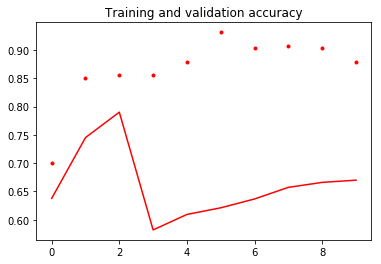

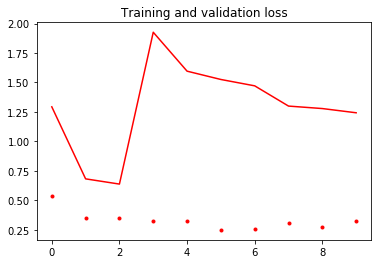

In [14]:
train(epochs = 10, output_model_file = 'new_model.h5')

### Validation accuracy achieved ~80%. 

## Predictions on test data

In [3]:
target_size = (299, 299) # for inceptionv3

In [4]:
def predict(model, img, target_size = target_size):
    img = cv2.imread(img)
    img = cv2.resize(img,(299,299))
    x = np.reshape(img,[299,299,3])
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    preds = model.predict(x)
    return preds[0]

In [25]:
def plot_preds(image, preds):
    labels = ("NORMAL", "PNEUMONIA")
    plt.barh([0, 1], preds, alpha=0.5)
    plt.yticks([0, 1], labels)
    plt.xlabel('Probabilities')
    plt.xlim(0,1.01)
    plt.tight_layout()

In [6]:
# Load saved model
model = load_model('weights_3.h5')

### 0: Normal    1: Pneumonia

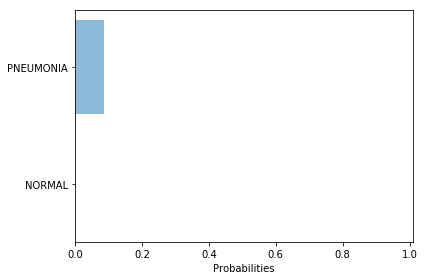

In [26]:
# Pred 1
img =  'test/PNEUMONIA/person48_virus_100.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [29]:
res = np.argmax(preds)
print(res)   

1


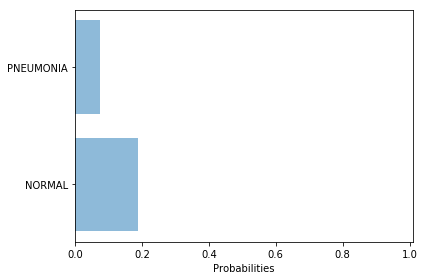

In [30]:
# Pred 2
img =  'test/NORMAL/IM-0105-0001.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [31]:
res = np.argmax(preds)
print(res)   

0


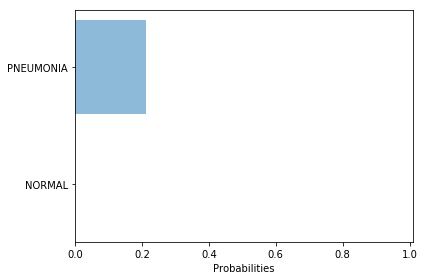

In [33]:
# Pred 3
img =  'test/PNEUMONIA/person1672_virus_2888.jpeg'
preds = predict(model, img)
plot_preds(img, preds)

In [34]:
res = np.argmax(preds)
print(res)   

1
